In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR


In [2]:
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {'GPU' if device.type == 'cuda' else 'CPU'}")


Using device: GPU


In [3]:
# Data transformations with augmentations for training and normalization for validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:
# Path to the organized dataset directory
img_dir = "./Datasets/eye-q/train_split"  # Path to your organized dataset

# Instantiate datasets
train_dataset = datasets.ImageFolder(root=img_dir, transform=train_transforms)

# For validation, you can use a separate directory (if available)
# Example for a validation set; adjust path if needed
# valid_dataset = datasets.ImageFolder(root="path/to/validation_data", transform=valid_transforms)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
#valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)  # Uncomment if using validation


In [5]:
# Initialize ResNet34 with dropout in the classifier
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 5)  # 5 output classes for diabetic retinopathy levels
)
model.to(device)


/home/karannaik503/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/karannaik503/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [7]:
# Assuming you have a separate validation dataset directory
valid_img_dir = "./Datasets/eye-q/valid_split"  # Path to your organized validation dataset

# Create a validation dataset
valid_dataset = datasets.ImageFolder(root=valid_img_dir, transform=valid_transforms)

# Create a DataLoader for the validation dataset
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


In [8]:
# # Early stopping parameters
# best_val_loss = float('inf')
# patience = 3
# early_stop_counter = 0

# # Training loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     running_loss, correct_preds = 0.0, 0

#     # Training phase
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
#         optimizer.zero_grad()  # Reset gradients
#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Calculate loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update weights

#         # Accumulate loss and correct predictions
#         running_loss += loss.item() * images.size(0)
#         _, preds = torch.max(outputs, 1)  # Get predicted classes
#         correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

#     # Calculate epoch metrics
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = correct_preds.double() / len(train_loader.dataset)

#     # Validation phase
#     model.eval()  # Set the model to evaluation mode
#     val_running_loss, val_correct_preds = 0.0, 0
#     with torch.no_grad():  # Disable gradient calculation
#         for images, labels in valid_loader:  # Iterate through validation data
#             images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
#             outputs = model(images)  # Forward pass
#             loss = criterion(outputs, labels)  # Calculate loss
#             val_running_loss += loss.item() * images.size(0)  # Accumulate validation loss
#             _, preds = torch.max(outputs, 1)  # Get predicted classes
#             val_correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

#     # Calculate validation metrics
#     val_loss_epoch = val_running_loss / len(valid_loader.dataset)
#     val_acc_epoch = val_correct_preds.double() / len(valid_loader.dataset)

#     # Print metrics for the current epoch
#     print(f"Epoch {epoch + 1}/{num_epochs}, "
#           f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
#           f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

#     # Scheduler step
#     scheduler.step()

#     # Early stopping check
#     if val_loss_epoch < best_val_loss:
#         best_val_loss = val_loss_epoch
#         early_stop_counter = 0
#         torch.save(model.state_dict(), 'best_resnet34_dr_detection.pth')  # Save best model
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print("Early stopping triggered.")
#             break


In [9]:
# #for validation dataset
# import os
# import random
# import shutil
# from pathlib import Path

# # Paths to the original dataset directory and the new split directories
# original_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/organized_train_dir_reduced")  # Original dataset directory
# train_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/reduced_train_split")  # Path for training data
# valid_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/reduced_valid_split")  # Path for validation data

# # Create directories for the new dataset
# train_dataset_dir.mkdir(parents=True, exist_ok=True)
# valid_dataset_dir.mkdir(parents=True, exist_ok=True)

# # Define the split ratio (e.g., 20% for validation)
# split_ratio = 0.2  # 20% for validation

# # Iterate through each class directory and split the images
# for class_dir in original_dataset_dir.iterdir():
#     if class_dir.is_dir():  # Check that it's a directory
#         class_label = class_dir.name
#         images = list(class_dir.glob("*.*"))  # Get all image files (adjust if necessary)

#         # Shuffle images
#         random.shuffle(images)
        
#         # Calculate the split index
#         split_index = int(len(images) * split_ratio)
        
#         # Split images into training and validation sets
#         valid_images = images[:split_index]
#         train_images = images[split_index:]

#         # Create class directories in the new dataset directories
#         (train_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)
#         (valid_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)

#         # Move images to the respective directories
#         for image_path in train_images:
#             shutil.copy(image_path, train_dataset_dir / class_label / image_path.name)
#         for image_path in valid_images:
#             shutil.copy(image_path, valid_dataset_dir / class_label / image_path.name)

# print("Dataset split complete. Training and validation datasets created.")


In [10]:
# #organizing half of the dataset
# import os
# import pandas as pd
# import shutil

# # Paths
# csv_path = r"E:\Mini Project\Datasets\eye-q\trainLabels.csv"  # Path to your CSV file
# image_folder = r"E:\Mini Project\Datasets\eye-q\train_dir_reduced"  # Path to the folder containing the reduced set of images
# output_folder = r"E:\Mini Project\Datasets\eye-q\organized_train_dir_reduced"  # Output folder to store organized images

# # Load the CSV file
# df = pd.read_csv(csv_path)

# # Ensure output directory exists
# os.makedirs(output_folder, exist_ok=True)

# # Track missing files
# missing_files = []

# # Organize images by class
# for _, row in df.iterrows():
#     image_name = row['image']
#     label = row['level']
    
#     # Define the source and destination paths
#     source_path = os.path.join(image_folder, f"{image_name}.jpeg")
#     destination_folder = os.path.join(output_folder, str(label))
#     destination_path = os.path.join(destination_folder, f"{image_name}.jpeg")
    
#     # Create the class folder if it doesn't exist
#     os.makedirs(destination_folder, exist_ok=True)
    
#     # Move image if it exists, otherwise log as missing
#     if os.path.exists(source_path):
#         shutil.move(source_path, destination_path)
#     else:
#         missing_files.append(source_path)

# # Log any missing files
# if missing_files:
#     with open("missing_files_log.txt", "w") as log_file:
#         for file in missing_files:
#             log_file.write(f"{file}\n")
#     print(f"Missing files have been logged to missing_files_log.txt.")

# print("Images have been organized by class.")


In [11]:
# #splitting half dataset after organizing
# import os
# import random
# import shutil
# from pathlib import Path

# # Paths
# original_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/organized_train")  # Path to organized dataset
# train_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/train_split")  # Training data path
# valid_dataset_dir = Path("E:/Mini Project/Datasets/eye-q/valid_split")  # Validation data path

# # Define split ratio (20% for validation) and reduction factor (50%)
# split_ratio = 0.2  # Validation set percentage
# reduction_factor = 0.5  # Reduce each class by half

# # Ensure directories exist
# train_dataset_dir.mkdir(parents=True, exist_ok=True)
# valid_dataset_dir.mkdir(parents=True, exist_ok=True)

# # Random seed for reproducibility
# random.seed(42)

# # Process each class directory
# for class_dir in original_dataset_dir.iterdir():
#     if class_dir.is_dir():
#         class_label = class_dir.name
#         images = list(class_dir.glob("*.*"))

#         # Reduce images by half
#         reduced_images = random.sample(images, int(len(images) * reduction_factor))

#         # Split reduced images into training and validation sets
#         split_index = int(len(reduced_images) * split_ratio)
#         valid_images = reduced_images[:split_index]
#         train_images = reduced_images[split_index:]

#         # Create class directories in train/validation folders
#         (train_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)
#         (valid_dataset_dir / class_label).mkdir(parents=True, exist_ok=True)

#         # Copy images to train/validation directories
#         for image_path in train_images:
#             shutil.copy(image_path, train_dataset_dir / class_label / image_path.name)
#         for image_path in valid_images:
#             shutil.copy(image_path, valid_dataset_dir / class_label / image_path.name)

# print("Dataset reduction and split complete. Training and validation sets created.")


In [12]:
#training with reduced organized dataset
import os
from pathlib import Path

# Log missing files if any, avoiding repeated checks during training
def log_missing_files(data_dir):
    missing_files = []
    for img_path in Path(data_dir).glob("**/*.jpeg"):  # Assuming .jpeg extension
        if not img_path.is_file():
            missing_files.append(str(img_path))
    if missing_files:
        with open("missing_files_log.txt", "w") as log_file:
            for item in missing_files:
                log_file.write(f"{item}\n")
        print("Missing files logged to missing_files_log.txt.")
    return missing_files

# Initial check for missing files in both train and validation directories
train_missing_files = log_missing_files("./Datasets/eye-q/train_split")
valid_missing_files = log_missing_files("./Datasets/eye-q/valid_split")

# Proceed only if there are no missing files (or handle as needed)
if not train_missing_files and not valid_missing_files:
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 3
    early_stop_counter = 0

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss, correct_preds = 0.0, 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():  # Disable gradient calculation
            for images, labels in valid_loader:  # Iterate through validation data
                images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                val_running_loss += loss.item() * images.size(0)  # Accumulate validation loss
                _, preds = torch.max(outputs, 1)  # Get predicted classes
                val_correct_preds += torch.sum(preds == labels.data)  # Count correct predictions

        # Calculate validation metrics
        val_loss_epoch = val_running_loss / len(valid_loader.dataset)
        val_acc_epoch = val_correct_preds.double() / len(valid_loader.dataset)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        # Scheduler step
        scheduler.step()

        # Early stopping check
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_resnet34_dr_detection.pth')  # Save best model
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
else:
    print("Some files are missing; check missing_files_log.txt for details.")


Epoch 1/20, Train Loss: 0.9265, Train Acc: 0.7224, Val Loss: 0.8643, Val Acc: 0.7329
Epoch 2/20, Train Loss: 0.8664, Train Acc: 0.7316, Val Loss: 0.7827, Val Acc: 0.7350
Epoch 3/20, Train Loss: 0.8185, Train Acc: 0.7356, Val Loss: 0.7618, Val Acc: 0.7390
Epoch 4/20, Train Loss: 0.8034, Train Acc: 0.7373, Val Loss: 0.7102, Val Acc: 0.7564
Epoch 5/20, Train Loss: 0.7816, Train Acc: 0.7434, Val Loss: 0.7145, Val Acc: 0.7618
Epoch 6/20, Train Loss: 0.7689, Train Acc: 0.7477, Val Loss: 0.6846, Val Acc: 0.7717
Epoch 7/20, Train Loss: 0.7481, Train Acc: 0.7506, Val Loss: 0.6703, Val Acc: 0.7727
Epoch 8/20, Train Loss: 0.7353, Train Acc: 0.7521, Val Loss: 0.6341, Val Acc: 0.7910
Epoch 9/20, Train Loss: 0.7198, Train Acc: 0.7600, Val Loss: 0.6257, Val Acc: 0.7931
Epoch 10/20, Train Loss: 0.7141, Train Acc: 0.7602, Val Loss: 0.6205, Val Acc: 0.7937
Epoch 11/20, Train Loss: 0.7075, Train Acc: 0.7644, Val Loss: 0.6283, Val Acc: 0.7880
Epoch 12/20, Train Loss: 0.7076, Train Acc: 0.7656, Val Loss: 0

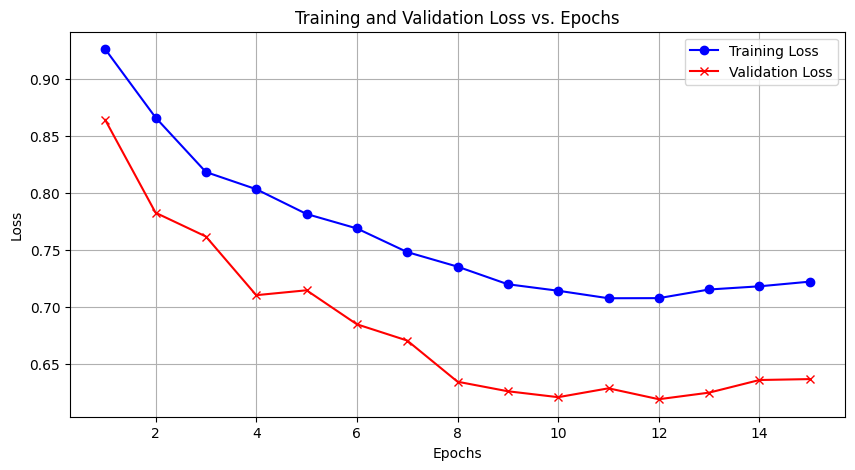

In [20]:
import matplotlib.pyplot as plt

# Replace these lists with the actual training and validation loss values from each epoch
train_losses = [
    0.9265, 0.8664, 0.8185, 0.8034, 0.7816, 0.7689, 0.7481, 0.7353, 0.7198, 0.7141, 
    0.7075, 0.7076, 0.7152, 0.7180, 0.7221
]
val_losses = [
    0.8643, 0.7827, 0.7618, 0.7102, 0.7145, 0.6846, 0.6703, 0.6341, 0.6257, 0.6205, 
    0.6283, 0.6187, 0.6245, 0.6356, 0.6364
]
epochs = list(range(1, len(train_losses) + 1))

# Plotting loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='b')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, data_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=1)
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm

# Example call with class names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your actual class names
report, cm = evaluate_model(model, valid_loader, device, class_names=class_names)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)



Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.99      0.89      2157
     Class 1       1.00      0.00      0.00       204
     Class 2       0.62      0.37      0.46       448
     Class 3       0.51      0.24      0.33        75
     Class 4       0.47      0.15      0.23        59

    accuracy                           0.79      2943
   macro avg       0.68      0.35      0.38      2943
weighted avg       0.78      0.79      0.74      2943

Confusion Matrix:
 [[2127    0   30    0    0]
 [ 198    0    6    0    0]
 [ 267    0  165   11    5]
 [  13    0   39   18    5]
 [  17    0   27    6    9]]


In [14]:
#Evaluation of the model

import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return precision, recall, f1, cm

# Example call using valid_loader for evaluation
precision, recall, f1, cm = evaluate_model(model, valid_loader, device)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Precision: 0.7112330175897663
Recall: 0.7879714576962283
F1 Score: 0.7356342171905675
Confusion Matrix:
[[2127    0   30    0    0]
 [ 198    0    6    0    0]
 [ 267    0  165   11    5]
 [  13    0   39   18    5]
 [  17    0   27    6    9]]


/home/karannaik503/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import torch
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class UnlabeledTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Add other formats if necessary
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_name


In [16]:

# Define the transformations
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Path to your test dataset
test_img_dir = "./Datasets/eye-q/test"  # Adjust this path if necessary

# Create a test dataset
test_dataset = UnlabeledTestDataset(img_dir=test_img_dir, transform=test_transforms)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [19]:
import pandas as pd
# Perform predictions on the test set and save results
model.eval()
image_names = []
predictions = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Remove the .jpeg extension from the image names
        img_names = [name.replace('.jpeg', '') for name in img_names]
        
        image_names.extend(img_names)
        predictions.extend(preds.cpu().numpy())

# Save test predictions to CSV
results_df = pd.DataFrame({
    "image": image_names,
    "level": predictions
})
results_df.to_csv("test_predictions-resnet34.csv", index=False)
print("Test predictions saved to 'test_predictions-resnet34.csv'")

Test predictions saved to 'test_predictions-resnet34.csv'
